# Introduction
This notebook describes the compression ratio and 10 other statistics for different types of Nengo models starting with simple communication models, moving up to a Nengo Circular Convolution model and finally, the Working Memory module contained in SPAUN.

The notebook is composed of three main sections. The first section describes the compression ratio and statistics for the simple models including communication, fanout and fanin networks. The second section describes the same material for the Circular Convolution model and the third section describes the same material for the Working memory module. 

Each section has the same structure starting with a short description of what is being modelled in the section. The section then provides equations for calculating the statistics The section then implements the equations in Python and finally verify that the equations are correct.

# Calculate compression for simple networks

This first section calculates the compression ratio and 10 other statistics for simple networks including a simple communication channel, a simple fanout network, and a simple fan-in network.

A simple communication channel looks as follows:

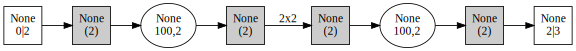

In [20]:
import nengo_brainstorm_pp.preprocessing as pp
from nengo_brainstorm import gv_utils
import numpy as np
import nengo

reload(gv_utils)

def make_fanout_network(fanout=1, use_identity_transforms=True):
    source_dims = 2
    dest_dims = 2
    n_neurons = 100
    if use_identity_transforms==True:
        transform=np.identity(source_dims)
    else:
        transform=np.ones(shape=(source_dims, dest_dims), dtype=int)
            
    comm_model = nengo.Network()
    with comm_model:
        a = nengo.Ensemble(n_neurons, source_dims)
        input_node = nengo.Node(np.random.randn(source_dims))
        nengo.Connection(input_node,a)
    
        def step(t,x):
            return 1,1,1
        for i in range(fanout):
            b = nengo.Ensemble(n_neurons, dest_dims)
            
            nengo.Connection(a,b,transform = transform)
            
            output_node = nengo.Node(step,size_in=2)
        
            nengo.Connection(b, output_node)
            
    return comm_model
        
comm_model = make_fanout_network(fanout=1,use_identity_transforms=True)
pp_comm_model = pp.preprocess(comm_model,find_io = False)
gv_utils.gv_plot(pp_comm_model)

A simple fanout network looks as follows:

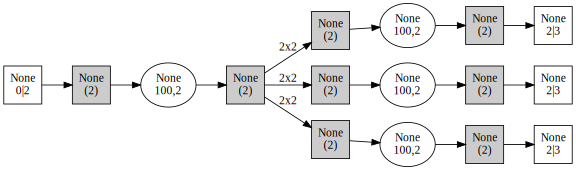

In [21]:
fanout_model = make_fanout_network(fanout=3, use_identity_transforms=True)
pp_fanout_model = pp.preprocess(fanout_model,find_io = False)
gv_utils.gv_plot(pp_fanout_model)

Finally, a simple fan-in network looks as follows:

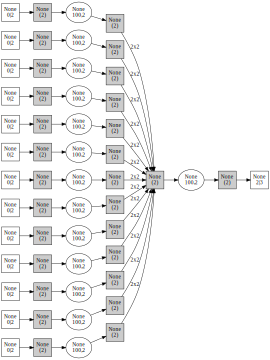

In [3]:
def make_fanin_network(fanin=1, use_identity_transforms=True):
    source_dims = 2
    dest_dims = 2
    n_neurons = 100
    comm_model = nengo.Network()
    with comm_model:
        def step(t,x):
            return 1,1,1
        
        a = nengo.Ensemble(n_neurons, source_dims)
        output_node = nengo.Node(step,size_in=2)
        nengo.Connection(a,output_node)
    
        for i in range(fanin):
            b = nengo.Ensemble(n_neurons, dest_dims)
            
            if use_identity_transforms==True:
                transform=np.identity(source_dims)
            else:
                transform=np.ones(shape=(source_dims, dest_dims), dtype=int)
                
            nengo.Connection(b,a,transform = transform)
            
            input_node = nengo.Node(np.random.randn(source_dims))
        
            nengo.Connection(input_node,b)
    return comm_model

fanin_model = make_fanin_network(fanin=13, use_identity_transforms=False)
pp_fanin_comm_model = pp.preprocess(fanin_model,find_io = False)
gv_utils.gv_plot(pp_fanin_comm_model)

## Statistics
This section provides formulas for the the statistics we are interested in.

### Total decoding weights
The total number of decoding weights is calculated as follows:<br><br>

$$N_\text{D}=\sum_{i=1}^{N_\text{ENS}}k_\text{i}d_\text{i}^2$$

where $N_\text{ENS}$ is the number of ensembles in the model, $k_\text{i}$ is the neurons per dimension of ensemble $\text{i}$ and $d_\text{i}$ is the decoding dimension of ensemble $\text{i}$.


### Total encoding weights
The total number of encoding weights is calculated as follows:<br><br>

$$N_\text{E}=\sum_{i=1}^{N_\text{ENS}}k_\text{i}d_\text{i}^2$$

where $N_\text{ENS}$ is the number of ensembles in the model, $k_\text{i}$ is the neurons per dimension of ensemble $\text{i}$ and $d_\text{i}$ is the encoding dimension of ensemble $\text{i}$.

<br>

### Total transform resource count
The total transform resource count is calculated as follows:<br><br>

$$N_\text{T}=
\sum_{i=1}^{N_\text{ENS}}\sum_{j=1}^{N_\text{FAN,i}}d_\text{i}d_\text{j} + \sum_{i=1}^{N_\text{ENS}}1
$$

where $N_\text{ENS}$ is the number of ensembles in the model, $N_\text{FAN,i}$ is the fanout of ensemble $\text{i}$, $d_\text{i}$ is the decoding dimensions of ensemble $\text{i}$ and $d_\text{j}$ is the encoding dimensions of ensemble $\text{j}$ receiving input from ensemble $\text{i}$.

### Total number of synapses
The total number of synapses is calculated as follows:<br><br>

$$N_\text{SYN}=
\sum_{i=1}^{N_\text{ENS}}\sum_{j=1}^{N_\text{FAN,i}}k_\text{i}d_\text{i}k_\text{j}d_\text{j}
$$

where $N_\text{ENS}$ is the number of ensembles in the model, $N_\text{FAN,i}$ is the fanout of ensemble $\text{i}$, $d_\text{i}$ is the decoding dimensions of ensemble $\text{i}$ and $d_\text{j}$ is the encoding dimensions of ensemble $\text{j}$ receiving input from ensemble $\text{i}$.


### Compression ratio
The compression ratio is calculated as follows:<br><br>

$$C=\frac{N_\text{E}+N_\text{D}+N_\text{T}}{N_\text{SYN}}$$

This is the total resources required for encoding weights, decoding weights and transforms divided by the the total number of synapses required by the network.

### Total number of neurons
The total number of neurons is calculated as follows:<br>
<br>


$$N_\text{NRN}=
\sum_{i=1}^{N\text_{ENS}}k_\text{i}d_\text{i}
$$

where $k_\text{i}$ is the neurons per dimension of ensemble $\text{i}$ and $d_\text{i}$ is the decoding dimensions of ensemble $\text{i}$.

### Total number of ensembles
$N_\text{ENS}$ is a count of the total number of ensembles in a given model.

### Fanout
The fanout is calculated as follows:<br><br>
$$
N_\text{FAN}=\sum_{i=1}^{N_\text{ENS}}N_\text{FAN,i}
$$

where $N_\text{FAN,i}$ is the fanout for ensemble $\text{i}$.

### Neurons per ensemble
The ratio of neurons to ensembles is defined as:<br><br>

$$R_\text{NRN-ENS}=\frac{N_\text{NRN}}{N_\text{ENS}}$$

### Synapses per neurons
The ratio of synapses to neurons is defined as:<br><br>

$$R_\text{SYN-NRN}=\frac{N_\text{SYN}}{N_\text{NRN}}$$

### Average fanout
The average fanout is defined as the fanout over the total number of ensembles:<br><br>

$$R_\text{FAN-ENS}=\frac{N_\text{FAN}}{N_\text{ENS}}$$

## Implementation

We now implement the equations above and test them on the three different models.

In [4]:
# implementation of equations for simple models

###################
# Calculating encoding weights
###################

# k_i is an array of ints representing the neurons per dimension for ensemble i
# d_i is an array of ints representing the encoding dimensions for ensemble i
def simple_encoding_weights(k_i, d_i):
    return_value = 0
    for i,k_i in enumerate(k_i):
        return_value += k_i*d_i[i]*d_i[i]
        
    return return_value

###################
# Calculating decoding weights
###################

# k_i is an array of ints representing the neurons per dimension for ensemble i
# d_i is an array of ints representing the encoding dimensions for ensemble i
def simple_decoding_weights(k_i, d_i):
    return_value = 0
    for i,k_i in enumerate(k_i):
        return_value += k_i*d_i[i]*d_i[i]
        
    return return_value

###################
# Calculating transform resource counts
###################

# d_i is an array of decoding dimensions for each ensemble in the model
# d_j is an list of arrays of encoding dimension where each list element 
# are the encoding dimensions of ensembles that corresponding ensemble i
# connects to
def simple_transform_counts(d_i,d_j):
    return_value = 0
    for i,dec in enumerate(d_i):
        fanout_ens = d_j[i]
        for enc in fanout_ens:
            return_value += dec*enc
            
    return_value += len(d_i)
    return return_value

###################
# Calculating synaptic weights
###################

# d_i is an array of decoding dimensions for each ensemble in the model
# d_j is an list of arrays of encoding dimension where each list element 
# are the encoding dimensions of ensembles that corresponding ensemble i
# connects to
def simple_synaptic_weights(k_i,d_i,k_j,d_j):
    return_value = 0
    for i,dec in enumerate(d_i):
        fanout_k = k_j[i]
        fanout_d = d_j[i]
        for j,enc in enumerate(fanout_k):
            return_value += k_i[i]*dec*fanout_k[j]*fanout_d[j]
            
    return return_value

###################
# Calculating compression ratio
###################

def simple_compression(k_i,d_i,k_j,d_j):
    return (simple_encoding_weights(k_i,d_i) + \
            simple_decoding_weights(k_i,d_i) + \
            simple_transform_counts(d_i,d_j)) / \
            float(simple_synaptic_weights(k_i,d_i,k_j,d_j))

###################
# Calculating number of neurons
###################

def simple_num_neurons(k_i,d_i):
    return_value = 0
    for i,nrn_per_dim in enumerate(k_i):
        return_value += nrn_per_dim*d_i[i]
        
    return return_value

###################
# Calculating number of ensembles
###################

def simple_num_ensembles(k_i):
    return len(k_i)

###################
# Calculating fanout
###################

def simple_fanout(k_j):
    return_value = 0
    for fanout in k_j:
        return_value += len(fanout)
        
    return return_value


def compare_stats(N_NRN, N_ENS, N_D, N_E, N_T, N_SYN, C, N_FAN, R_NRN_ENS, R_SYN_NRN, R_FAN_ENS, stats):
    all_passed = True
    if (abs(N_NRN - stats['N_NRN']) > 0):
        print "N_NRN test fails"
        all_passed = False      
    if (abs(N_ENS - stats['N_ENS']) > 0):
        print "N_ENS test fails"
        all_passed = False    
    if (abs(N_D - stats['N_D']) > 0):
        print "N_D test fails"
        all_passed = False    
    if (abs(N_E - stats['N_E']) > 0):
        print "N_E test fails"
        all_passed = False    
    if (abs(N_T - stats['N_T']) > 0):
        print "N_T test fails"
        all_passed = False    
    if (abs(N_SYN - stats['N_SYN']) > 0):
        print "N_SYN test fails"
        all_passed = False    
    if (abs(C - stats['C']) > 0.00001):
        print "C test fails"
        all_passed = False    
    if (abs(N_FAN - stats['N_FAN']) > 0):
        print "N_FAN test fails"
        all_passed = False    
    if (abs(R_NRN_ENS - stats['R_NRN_ENS']) > 0.00001):
        print "R_NRN_ENS test fails"
        all_passed = False    
    if (abs(R_SYN_NRN - stats['R_SYN_NRN']) > 0.00001):
        print "R_SYN_NRN test fails"
        all_passed = False    
    if (abs(R_FAN_ENS - stats['R_FAN_ENS']) > 0.00001):
        print "R_FAN_ENS test fails"
        all_passed = False    
        
    if all_passed:
        print "All tests passed"
    else:
        print "Some tests failed"
        


where the following variables are defined per model:

$ k_\text{i}$ - an array where each element contains the neurons per dimension for ensemble $\text{i}$

$ d_\text{i}$ - an array where each element contains the decoding dimensions for ensemble $\text{i}$

$ k_\text{j,i}$ - a list of arrays where each element of the list corresponds to an array of neurons per dimension for ensemble $\text{j}$ where ensemble $\text{j}$ fans out from ensemble $\text{i}$.

$ d_\text{j,i}$ - a list of arrays where each element of the list corresponds to an array of encoding dimensions for ensemble $\text{j}$ where ensemble $\text{j}$ fans out from ensemble $\text{i}$.

## Verification

Given models for a simple communication channel, fanin and fanout network as well as the equations above, we can verify that our equations are correct.

For the simple communication model, we define $k_\text{i}$, $d_\text{i}$, $k_\text{j}$ and $d_\text{j}$ as follows:

In [5]:
# we know each ensemble has 50 neurons per dimension, with 2 decoding dimensions. In addition, the first ensemble fans
# out to one ensemble with 50 neurons per dimension and 2 encoding dimensions. Finally, the second ensemble fans out
# to a Node with 1 encoding dimension.
k_i=[50,50]
d_i=[2,2]
k_j=([50],[])
d_j=([2],[])

N_NRN = simple_num_neurons(k_i,d_i)
N_ENS = simple_num_ensembles(k_i)
N_D = simple_decoding_weights(k_i,d_i)
N_E = simple_encoding_weights(k_i,d_i)
N_T = simple_transform_counts(d_i,d_j)
N_SYN = simple_synaptic_weights(k_i,d_i,k_j,d_j)
C = simple_compression(k_i,d_i,k_j,d_j)
N_FAN = simple_fanout(k_j)
R_NRN_ENS = float(N_NRN/float(N_ENS))
R_SYN_NRN = float(N_SYN/float(N_NRN))
R_FAN_ENS = float(N_FAN/float(N_ENS))
print "Simple number of neurons = ",N_NRN
print "Simple number of ensembles = ", N_ENS
print "Simple decoding weights =", N_D
print "Simple encoding weights =", N_E
print "Simple transform resource count=", N_T
print "Simple number of synapses = ", N_SYN
print "Simple compression ratio = %.8f" % C
print "Simple fanout = ", N_FAN
print "Avg. neurons per ensemble = %.2f" % R_NRN_ENS
print "Avg. synapses per neuron = %.2f " % R_SYN_NRN
print "Avg. fanout = %.2f" % R_FAN_ENS

Simple number of neurons =  200
Simple number of ensembles =  2
Simple decoding weights = 400
Simple encoding weights = 400
Simple transform resource count= 6
Simple number of synapses =  10000
Simple compression ratio = 0.08060000
Simple fanout =  1
Avg. neurons per ensemble = 100.00
Avg. synapses per neuron = 50.00 
Avg. fanout = 0.50


We now verify the equations results against the results we get when we count values directly from the model.

In [6]:
import compute_stats as cp
stats = cp.compute_stats(pp_comm_model,print_results=False)
compare_stats(N_NRN, N_ENS, N_D, N_E, N_T, N_SYN, C, N_FAN, R_NRN_ENS, R_SYN_NRN, R_FAN_ENS, stats)

All tests passed


The statistics match.

We can run the same test agains the simple fanout model

In [7]:
k_i=[50,50,50,50]
d_i=[2,2,2,2]
k_j=([50,50,50],[],[],[])
d_j=([2,2,2],[],[],[])

N_NRN = simple_num_neurons(k_i,d_i)
N_ENS = simple_num_ensembles(k_i)
N_D = simple_decoding_weights(k_i,d_i)
N_E = simple_encoding_weights(k_i,d_i)
N_T = simple_transform_counts(d_i,d_j)
N_SYN = simple_synaptic_weights(k_i,d_i,k_j,d_j)
C = simple_compression(k_i,d_i,k_j,d_j)
N_FAN = simple_fanout(k_j)
R_NRN_ENS = float(N_NRN/float(N_ENS))
R_SYN_NRN = float(N_SYN/float(N_NRN))
R_FAN_ENS = float(N_FAN/float(N_ENS))
print "Simple number of neurons = ",N_NRN
print "Simple number of ensembles = ", N_ENS
print "Simple decoding weights =", N_D
print "Simple encoding weights =", N_E
print "Simple transform resource count=", N_T
print "Simple number of synapses = ", N_SYN
print "Simple compression ratio = %.8f" % C
print "Simple fanout = ", N_FAN
print "Avg. neurons per ensemble = %.2f" % R_NRN_ENS
print "Avg. synapses per neuron = %.2f " % R_SYN_NRN
print "Avg. fanout = %.2f" % R_FAN_ENS

Simple number of neurons =  400
Simple number of ensembles =  4
Simple decoding weights = 800
Simple encoding weights = 800
Simple transform resource count= 16
Simple number of synapses =  30000
Simple compression ratio = 0.05386667
Simple fanout =  3
Avg. neurons per ensemble = 100.00
Avg. synapses per neuron = 75.00 
Avg. fanout = 0.75


We now verify the equations results against the results we get when we count values directly from the model.

In [8]:
import compute_stats as cp
stats = cp.compute_stats(pp_fanout_model,print_results=False)
compare_stats(N_NRN, N_ENS, N_D, N_E, N_T, N_SYN, C, N_FAN, R_NRN_ENS, R_SYN_NRN, R_FAN_ENS, stats)

All tests passed


Again, the statistics match.

As a third example, we can look at the fanin model.

In [9]:
k_i=[50,50,50,50,50,50,50,50,50,50,50,50,50,50]
d_i=[2,2,2,2,2,2,2,2,2,2,2,2,2,2]
k_j=([50,50,50,50,50,50,50,50,50,50,50,50,50],[],[],[],[],[],[],[],[],[],[],[],[],[])
d_j=([2,2,2,2,2,2,2,2,2,2,2,2,2],[],[],[],[],[],[],[],[],[],[],[],[],[])

N_NRN = simple_num_neurons(k_i,d_i)
N_ENS = simple_num_ensembles(k_i)
N_D = simple_decoding_weights(k_i,d_i)
N_E = simple_encoding_weights(k_i,d_i)
N_T = simple_transform_counts(d_i,d_j)
N_SYN = simple_synaptic_weights(k_i,d_i,k_j,d_j)
C = simple_compression(k_i,d_i,k_j,d_j)
N_FAN = simple_fanout(k_j)
R_NRN_ENS = float(N_NRN/float(N_ENS))
R_SYN_NRN = float(N_SYN/float(N_NRN))
R_FAN_ENS = float(N_FAN/float(N_ENS))
print "Simple number of neurons = ",N_NRN
print "Simple number of ensembles = ", N_ENS
print "Simple decoding weights =", N_D
print "Simple encoding weights =", N_E
print "Simple transform resource count=", N_T
print "Simple number of synapses = ", N_SYN
print "Simple compression ratio = %.8f" % C
print "Simple fanout = ", N_FAN
print "Avg. neurons per ensemble = %.2f" % R_NRN_ENS
print "Avg. synapses per neuron = %.2f " % R_SYN_NRN
print "Avg. fanout = %.2f" % R_FAN_ENS

Simple number of neurons =  1400
Simple number of ensembles =  14
Simple decoding weights = 2800
Simple encoding weights = 2800
Simple transform resource count= 66
Simple number of synapses =  130000
Simple compression ratio = 0.04358462
Simple fanout =  13
Avg. neurons per ensemble = 100.00
Avg. synapses per neuron = 92.86 
Avg. fanout = 0.93


We now verify the equations results against the results we get when we count values directly from the model.

In [10]:
import compute_stats as cp
stats = cp.compute_stats(pp_fanin_comm_model,print_results=False)
compare_stats(N_NRN, N_ENS, N_D, N_E, N_T, N_SYN, C, N_FAN, R_NRN_ENS, R_SYN_NRN, R_FAN_ENS, stats)

All tests passed


And again, the statistics match.


# Calculate compression for Nengo Circular Convolution model

We now move on to calculating the compression ratio and other statistics for a preprocessed Circular Convolution Nengo model. The following is an example of such a model instantiated with 2-dimensional semantic pointers and 1-dimensional input/output layer ensembles.

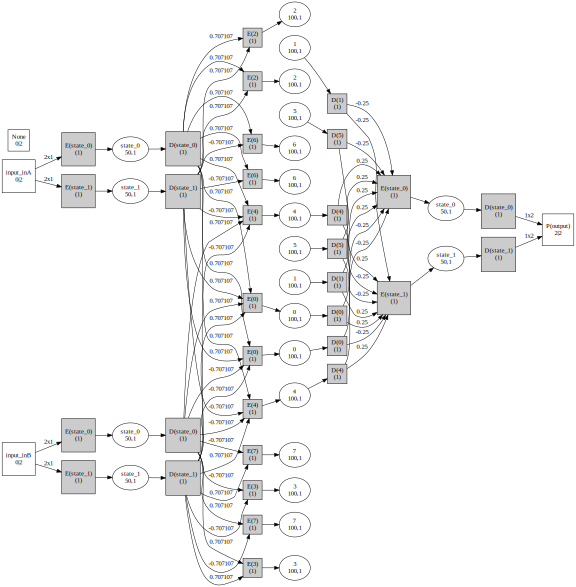

In [11]:
%%capture
import nengo
import nengo_brainstorm_pp as pp
import nengo.spa as spa

def make_conv_network(dims=8,subdims=2,pstc=0.01):
    model = spa.SPA()                                                       
    with model:                                                             
        model.inA = spa.Buffer(dims, subdimensions=subdims)                     
        model.inB = spa.Buffer(dims, subdimensions=subdims)                     
                                                                                
        model.result = spa.Buffer(dims, subdimensions=subdims)                  
                                                                                
        model.cortical = spa.Cortical(spa.Actions('result = inA * inB'),       
                                      synapse=pstc)                       
                                                                                
        model.input = spa.Input(inA='A', inB='B')                           
                                                                                
        probe = nengo.Probe(model.result.state.output, synapse=pstc) 
                                                                                
        ideal = nengo.Node(model.get_output_vocab('inA').parse('A*B').v)       
        probe_ideal = nengo.Probe(ideal, synapse=None)                 
    return model  

# These variables are modified when instantiating a Circular Convolution model.
D=2
d_IO=1

intro_conv_model = make_conv_network(dims=D,subdims=d_IO)
intro_pp_conv_model = pp.preprocess(intro_conv_model,find_io = False)
from nengo_brainstorm_pp import gv_utils
gv_utils.gv_plot(intro_pp_conv_model,size=(8,20))

In a preprocessed Nengo Circular convolution model, there are specific properties that will be true regardless of the user-specified semantic pointer and input/output layer ensemble dimensions. First, there will always be three layers of ensembles with the first and last layers referred to as the input and output layers respectively and the third layer referred to as the middle layer. Second, when an Ensemble in one layer is connected to an Ensemble in another layer, the Ensembles will have two Nodes between them. Third, any Node connected to an Ensemble in the middle layer will have a dimension of 1. Finally, for the Ensembles in the input and output layers, any Nodes going into or out of the Ensembles will have the same dimension, the user-specified input/output layer dimension.

The following sub-sections
- provide formulas for the compression ratio and the 10 other statistics we are interested, 
- provide statistics for a preprocessed Nengo Circular convolution model with 512-dimensional semantic pointers and 1-dimensional input/output layer dimensions, 
- verify the results

## Statistics
This section provides formulas for the the statistics we are interested in. The formulas use the following five variables. 

$D =$ Semantic pointer dimensions

$d_\text{IO} =$ Dimensions for ensembles in the input and output layers

$d_\text{M} =$ Dimensions for ensembles in the middle layer

$k_\text{IO} =$ Neurons per dimension in the input and output layers

$k_\text{M} =$ Neurons per dimension in the middle layer

The variables $D$ and $d_\text{IO}$ are provided to Nengo when instantiating a CircularConvolution model. The variables $d_\text{M}$, $k_\text{IO}$ and $k_\text{M}$ are not provided by the user during instantiation but are contained in the Nengo algorithms which instantiate and preprocess the CircularConvolution model.

The 11 statistics we are interested in are as follows.

### Total decoding weights
The total number of decoding weights is calculated as follows:<br><br>

$$N_\text{D}=3\frac{D}{d_\text{IO}}k_\text{IO}d_\text{IO}^2 + 4Dk_\text{M}d_\text{M}^2$$

The first product calculates the number of decoding weights in the input and output layers. The second product calculates the number of decoding weights in the middle layer.

### Total encoding weights
The total number of encoding weights is calculated as follows:<br><br>

$$N_\text{E}=
\begin{cases}
3\frac{D}{d_\text{IO}}k_\text{IO}d_\text{IO}^2 + (4D + 4)k_\text{M}d_\text{M}^2 & \text{if }D\text{ is even} \\
3\frac{D}{d_\text{IO}}k_\text{IO}d_\text{IO}^2 + (4D + 2)k_\text{M}d_\text{M}^2 & \text{if }D\text{ is odd} 
\end{cases}$$

The first product calculates the number of encoding weights in the input and output layers. The second product calculates the number of encoding weights for the middle layer. 
<br>

### Total transform resource count
The total transform resource count is calculated as follows:<br><br>

$$N_\text{T}=
\begin{cases}
12D^2 + 6D & \text{if } d_\text{IO} != 1\\
12D^2 + 6D - (12 \cdot \sum_{p=0}^{D} \sum_{q=1}^{\frac{D}{2}}\delta((4pq)\bmod{D})) & \text{if } d_\text{IO} == 1 \text{ and } D\text{ is even} \\
12D^2 + 6D - 6(D - 1 + \sum_{p=2}^{D} \sum_{q=2}^{D}\delta((pq)\bmod{D})) & \text{if } d_\text{IO} == 1 \text{ and } D\text{ is odd}
\end{cases}
$$

If the number of user-specified dimensions for the input/output layer Ensembles is greater than 1, the total transform resource count is simply $12D^2$. If, however, the user-specified dimensions for the input/output layer Ensembles is equal to 1, the transform resource count is reduced. This reduction is due to the number of DFT matrix coefficients used in the connection transforms between the input and middle layer Ensembles that have value 0. If the same DFT coefficient for both inputs has value 0, the inputs will not contribute to the total transform resource count and since the formula starts off assuming all inputs contribute to the total resource count, the non-contributing inputs must be subtracted from the total. The amount subtracted, however, depends on whether the semantic pointer dimensions is even or odd since this can affect the size of the DFT matrix and thus the amount to subtract from the initial resource count value.

### Total number of synapses
The total number of synapses is calculated as follows:<br><br>
$$
N_\text{SYN}= (N_\text{T} - 6D)k_\text{IO}k_\text{M}
$$<br>

This formula takes advantage of specific properties of a preprocessed CircularConvolution network. First, there are only three layers in the network, input, middle and output. Second, the since the input and output layers have the same neurons per dimension ratio ($k_\text{IO}$), the total synaptic count between an input layer ensemble and a middle layer ensemble is equal to the synaptic connection count between a middle layer ensemble and an output layer ensemble. Third, preprocessing this network guarantee's that for two ensembles, there will be at most one connection. Fourth, regardless of the $D$ and $d_\text{IO}$ chosen to define the system, the number of neurons in the input and output layers times the output/dimensions to those ensembles will always be equal to $k_\text{IO}$. This means that we can use the total transform resource count ($N_\text{T}$) and the neurons per dimension ratios ($k_\text{IO}$ and $k_\text{M}$) to determine the total number of synapses.

### Compression ratio
The compression ratio is calculated as follows:<br><br>

$$C=\frac{N_\text{E}+N_\text{D}+N_\text{T}}{N_\text{SYN}}$$

This is the total resources required for encoding weights, decoding weights and transforms divided by the the total number of synapses required by the network.

### Total number of neurons
The total number of neurons is calculated as follows:<br>
<br>

$$N_\text{NRN}=
\begin{cases}
3\frac{D}{d_\text{IO}}k_\text{IO}d_\text{IO} + (4D + 8)k_\text{M}d_\text{M} & \text{if } D\text{ is even} \\
3\frac{D}{d_\text{IO}}k_\text{IO}d_\text{IO} + (4D + 4)k_\text{M}d_\text{M} & \text{if } D\text{ is odd}
\end{cases}
$$
<br>
where the first term sums up the number of neurons in the input and output layers and the second terms sums up the number of neurons in the middle layer.

### Total number of ensembles
The total number of ensembles is calculated as follows:<br><br>

$$N_\text{ENS}=
\begin{cases}
3\frac{D}{ d_\text{IO} }+ 4D + 8 & \text{if } D\text{ is even} \\
3\frac{D}{ d_\text{IO} } + 4D + 4 & \text{if } D\text{ is odd}
\end{cases}
$$

<br>
where the first term sums up the number of ensembles in the input and output layers and the second terms sums up the number of ensembles in the middle layer.


### Fanout
The fanout is calculated as follows:<br><br>
$$
N_\text{fan}=\frac{N_\text{T} - 6D}{d_\text{IO}}
$$

This formula defines the fanout because of specific properties of a preprocessed CircularConvolution network. Given a preprocessed CircularConvolution network, each transform from the input layer to the middle layer will always be size $(d_\text{IO} \times 1)$, each transform from the middle layer to the output layer will always be size $(d_\text{M} \times d_\text{IO})$ and $d_\text{M}$ will always be 1. Therefore, $N_\text{T}$'s value will equal $d_\text{IO}$ times the total number of connections, also refered to as the fanout. The fanout, therefore, is simply derived by dividing $N_\text{T}$ by $d_\text{IO}$.

### Neurons per ensemble
The ratio of neurons to ensembles is defined as:<br><br>

$$R_\text{NRN-ENS}=\frac{N_\text{NRN}}{N_\text{ENS}}$$

### Synapses per neurons
The ratio of synapses to neurons is defined as:<br><br>

$$R_\text{SYN-NRN}=\frac{N_\text{SYN}}{N_\text{NRN}}$$

### Average fanout
The average fanout is defined as the fanout over the total number of ensembles:<br><br>

$$R_\text{FAN-ENS}=\frac{N_\text{FAN}}{N_\text{ENS}}$$

## Circular convolution network with 512-D semantic pointers

## Implementation

Given the formulas, we now test the formula's with a common sized Circular convolution model, a model with 512-D semantic pointer.
First, we build and preprocess the network.

In [12]:
%%capture
import nengo
import nengo_brainstorm_pp as pp
import nengo.spa as spa

def make_conv_network(dims=8,subdims=2,pstc=0.01):
    model = spa.SPA()                                                       
    with model:                                                             
        model.inA = spa.Buffer(dims, subdimensions=subdims)                     
        model.inB = spa.Buffer(dims, subdimensions=subdims)                     
                                                                                
        model.result = spa.Buffer(dims, subdimensions=subdims)                  
                                                                                
        model.cortical = spa.Cortical(spa.Actions('result = inA * inB'),       
                                      synapse=pstc)                       
                                                                                
        model.input = spa.Input(inA='A', inB='B')                           
                                                                                
        probe = nengo.Probe(model.result.state.output, synapse=pstc) 
                                                                                
        ideal = nengo.Node(model.get_output_vocab('inA').parse('A*B').v)       
        probe_ideal = nengo.Probe(ideal, synapse=None)                 
    return model  

# These variables are modified when instantiating a Circular Convolution model.
D=3
d_IO=1

large_conv_model = make_conv_network(dims=D,subdims=d_IO)
large_pp_conv_model = pp.preprocess(large_conv_model,find_io = False)

Now, we implement a set of functions from the formula's described above

In [13]:
# These variables should not be modified since they are dependent on the structure of a preprocessed
# Circular Convolution Nengo network and will not change when the user changes the variables they have control
# over (D and d_IO).
# These variables should only change if the algorithms for creating the CircularConvolution network or 
# the algorithms for preprocessing a Nengo network change.

k_IO = 50
k_M = 100
d_M=1

###################
# Calculating encoding weights
###################

def _cconv_io_layer_enc_dec_weights(D,d_IO,k_IO):
    return 3*(D/d_IO)*k_IO*(d_IO**2)

def _cconv_middle_layer_enc_weights(D,d_M,k_M):
    result = 0
    
    if D % 2 == 1:
        result = ((4*D)+2)*k_M*(d_M**2)
    else:
        result = ((4*D)+4)*k_M*(d_M**2)
    
    return result

def _cconv_encoding_weights(D,d_IO,k_IO,d_M,k_M):
    return _cconv_io_layer_enc_dec_weights(D,d_IO,k_IO) + \
           _cconv_middle_layer_enc_weights(D,d_M,k_M)

###################
# Calculating decoding weights
###################

def _cconv_middle_layer_dec_weights(D,d_M,k_M):
    return (4*D)*k_M*(d_M**2)

def _cconv_decoding_weights(D,d_IO,k_IO,d_M,k_M):
    return _cconv_io_layer_enc_dec_weights(D,d_IO,k_IO) + \
           _cconv_middle_layer_dec_weights(D,d_M,k_M)

###################
# Calculating transform resource counts
###################
# if the number of dimensions is odd
def _cconv_tr_odd(D,d_IO):
    result = 0
    if d_IO == 1:
        result += D - 1
        for p in range(2,D):
            for q in range(2,D):
                if ((p*q) % D) == 0:
                    result += 1
    return result

# if the number of dimensions is even
def _cconv_tr_even(D):
    result = 0
    if d_IO == 1:
        for p in range(0,D):
                for q in range(1,D/2):
                    if (4*(p*q) % D) == 0:
                        result += 1

    return result

def _cconv_input_to_middle_layer(D,d_IO):
    result = 8 * (D**2)
    if D % 2 == 0:
        result -= (8*_cconv_tr_even(D))
    else:
        result -= (4*_cconv_tr_odd(D,d_IO))
    return result

def _cconv_transform_counts(D,d_IO):
    return int(1.5 * _cconv_input_to_middle_layer(D,d_IO) + 6*D)

###################
# Calculating synaptic weights
###################

def _cconv_synaptic_weights(D,d_IO,k_IO,k_M):
    return (_cconv_transform_counts(D,d_IO) - 6*D) * k_IO * k_M

###################
# Calculating compression ratio
###################

def cconv_compression(D,d_IO,k_IO,d_M,k_M):
    return (_cconv_encoding_weights(D,d_IO,k_IO,d_M,k_M) + \
            _cconv_decoding_weights(D,d_IO,k_IO,d_M,k_M) + \
            _cconv_transform_counts(D,d_IO)) / \
             float(_cconv_synaptic_weights(D,d_IO,k_IO,k_M))

###################
# Calculating number of neurons
###################

def cconv_num_neurons(D,d_IO,k_IO,d_M,k_M):
    return (3*(D/d_IO)*k_IO*(d_IO)) + (8*(D//2 + 1)*k_M*d_M)

###################
# Calculating number of ensembles
###################

def cconv_num_ensembles(D,d_IO):
    return 3*(D/d_IO) + 8*(D//2 + 1)

###################
# Calculating fanout
###################

def cconv_fanout(D,d_IO):
    return (_cconv_transform_counts(D,d_IO) - 6*D)/d_IO

Use the formulas, we can obtain the compression ratio and other statistics as a function of $D$ and $d_\text{IO}$.

In [14]:
###################
# Determine relevant statistics
###################

N_NRN = cconv_num_neurons(D,d_IO,k_IO,d_M,k_M)
N_ENS = cconv_num_ensembles(D,d_IO)
N_D   = _cconv_decoding_weights(D,d_IO,k_IO,d_M,k_M)
N_E   = _cconv_encoding_weights(D,d_IO,k_IO,d_M,k_M)
N_T   = _cconv_transform_counts(D,d_IO)
N_SYN = _cconv_synaptic_weights(D,d_IO,k_IO,k_M)
C     =  cconv_compression(D,d_IO,k_IO,d_M,k_M)
N_FAN = cconv_fanout(D,d_IO)
R_NRN_ENS = float(N_NRN/float(N_ENS))
R_SYN_NRN = float(N_SYN/float(N_NRN))
R_FAN_ENS = float(N_FAN/float(N_ENS))

print "CConv number of neurons = ",N_NRN
print "CConv number of ensembles = ", N_ENS
print "CConv decoding weights =", N_D
print "CConv encoding weights =", N_E
print "CConv transform resource count=", N_T
print "CConv number of synapses = ", N_SYN
print "CConv compression ratio = %.8f" % C
print "CConv fanout = ", N_FAN
print "Avg. neurons per ensemble = %.2f" % R_NRN_ENS
print "Avg. synapses per neuron = %.2f " % R_SYN_NRN
print "Avg. fanout = %.2f" % R_FAN_ENS

CConv number of neurons =  2050
CConv number of ensembles =  25
CConv decoding weights = 1650
CConv encoding weights = 1850
CConv transform resource count= 114
CConv number of synapses =  480000
CConv compression ratio = 0.00752917
CConv fanout =  96
Avg. neurons per ensemble = 82.00
Avg. synapses per neuron = 234.15 
Avg. fanout = 3.84


## Verification
-

In [15]:
import compute_stats as cp
stats = cp.compute_stats(large_pp_conv_model,print_results=True)
def compare_stats(N_NRN, N_ENS, N_D, N_E, N_T, N_SYN, C, N_FAN, R_NRN_ENS, R_SYN_NRN, R_FAN_ENS, stats):
    all_passed = True
    if (abs(N_NRN - stats['N_NRN']) > 0):
        print "N_NRN test fails"
        all_passed = False      
    if (abs(N_ENS - stats['N_ENS']) > 0):
        print "N_ENS test fails"
        all_passed = False    
    if (abs(N_D - stats['N_D']) > 0):
        print "N_D test fails"
        all_passed = False    
    if (abs(N_E - stats['N_E']) > 0):
        print "N_E test fails"
        all_passed = False    
    if (abs(N_T - stats['N_T']) > 0):
        print "N_T test fails"
        all_passed = False    
    if (abs(N_SYN - stats['N_SYN']) > 0):
        print "N_SYN test fails"
        all_passed = False    
    if (abs(C - stats['C']) > 0.00001):
        print "C test fails"
        all_passed = False    
    if (abs(N_FAN - stats['N_FAN']) > 0):
        print "N_FAN test fails"
        all_passed = False    
    if (abs(R_NRN_ENS - stats['R_NRN_ENS']) > 0.00001):
        print "R_NRN_ENS test fails"
        all_passed = False    
    if (abs(R_SYN_NRN - stats['R_SYN_NRN']) > 0.00001):
        print "R_SYN_NRN test fails"
        all_passed = False    
    if (abs(R_FAN_ENS - stats['R_FAN_ENS']) > 0.00001):
        print "R_FAN_ENS test fails"
        all_passed = False    
        
    if all_passed:
        print "All tests passed"
    else:
        print "Some tests failed"
        
compare_stats(N_NRN, N_ENS, N_D, N_E, N_T, N_SYN, C, N_FAN, R_NRN_ENS, R_SYN_NRN, R_FAN_ENS, stats)


Total number of neurons = 2050
Total number of ensembles = 25
Total number of synapses = 480000
Total fanout = 96
Total decoding weights = 1650
Total encoding weights = 1850
Total transform resource count = 114

Compression = 0.007529

Average number of neurons per ensemble = 82.00
Average number of synapses per neuron = 234.15
Average fanout = 3.84
All tests passed


The text "All tests passed" tells us that the formulas match the values we got from evaluating the model by counting programmatically.

# Calculate compression for WorkingMemory module
Finally, we look at the compression ratio and 10 other statistics for a preprocessed SPAUN WorkingMemory module. The module is one of several used in the SPAUN model and is used in this notebook to illustrate the compression we can achieve with SPAUN. 

The following network diagram illustrates the top level structure of the WorkingMemory module.

![Top level view of the WorkingMemory module](./working_memory_module.png)

From this diagram, we see the module is composed of the following types of blocks:
* Nodes
    * Nodes are labelled MB1_Gate_Node, MB2_Gate_Node, MB3_Gate_Node, bias_node and num0_bias_node. They do not contribute to the TAT entries considered in this notebook. 
* Selector blocks
    * The Selector blocks labelled sel_mb1_in, sel_mb2_in and sel_mb3_in. 
* Memory blocks
    * The Memory blocks labelled MBAve, MB1A, MB1B, MB2A, MB2B, MB3A and MB3B.
* Gate blocks
    * The Gate blocks all labelled gate.
* "Signal" blocks
    * "Signal" blocks are labelled cnt_gate_sig, gate_sig_bias and mbave_norm. The structure of these blocks are simply an Ensemble connected to a Node. 

A Selector block has three input Nodes and three EnsembleArrays. Each EnsembleArray in SPAUN has 512-dimensional input and one sub-Ensemble per input dimension. 
 
The following network diagram was created with Nengo GUI and shows a single Selector block. The Selector block in this example has three selection Nodes and three EnsembleArrays configured with 2 dimensional inputs.
<img src="selector_block_2_dims.png">

The Nodes labelled in_node_0, in_node_1 and in_node_2 are not part of the Selector block and were added for illustration purposes. These Nodes are connected to the Selector blocks input Nodes labelled sel0, sel1 and sel2. The input Nodes then form connections to the EnsembleArrays sub-Ensembles as well as an Ensemble that labelled sel_none. 

A single Memory block is shown in the following diagram with two input gated inhibitor circuits labelled mem1 and mem2. Each input gated inhibitor circuit has the same structure with three Ensembles, a bias Node and three EnsembleArrays. Each EnsembleArrays, in this example, has two input dimensions and thus two sub-Ensembles. In addition, two of the EnsembleArrays have sub-Ensembles whose neurons are connected to by external Ensembles. 
<img src="memory_block_2_dims.png">

The Nodes labelled in_node_0, in_node_1 and in_node_2 are not part of the Memory block and were added for illustration purposes. These nodes are connected to the Memory blocks input, gate and reset Nodes. 

A single Gate block is shown in the following diagram. The block consists of an EnsembleArray and an Ensemble with connections to the EnsembleArray's sub-Ensemble's neurons. In this example, the EnsembleArray was configured with 2 dimensional input.
<img src="gate_block_2_dims.png">

The Node labelled in_node_0 is not part of the Gate block and was added for illustration purposes. This Node is connected to the Gate blocks Ensemble labelled gate. 

When calculating the statistics for a single preprocessed SPAUN module, bear in mind, the modules inputs and outputs from other modules may not be instantiated and, therefore, the Nodes and Ensembles in WorkingMemory may not be connected to Nodes and Ensembles from other modules. If this is the case, preprocessing can eliminate Nodes if the Nodes have no input connection as well as encoding or decoding Ensemble weights if the Ensemble has no input or output connection respectively. If a Node or encoding/decoding weight is eliminated, the statistics (e.g. the total encoding weights) are smaller than they would be when the WorkingMemory module is instantiated in a full SPAUN module. 

The following sections
- provide formulas for the compression ratio and the 10 other statistics we are interested, 
- provide statistics for a preprocessed SPAUN WorkingMemory module with 512-dimensional semantic pointers.
- verify the results

## Statistics
This section provides formulas for the the statistics we are interested in. The formulas use the following four variables. 

$D$ = semantic pointer dimensions

$k_1$  = number of neurons per Ensemble dimension

$k_2$ = number of neurons per Ensemble dimension

$d_1$ = input/output dimensions of an Ensemble 

The variable $D$ is provided to Nengo when instantiating SPAUNs WorkingMemory module. The variables $k_1$, $k_2$ and $d_1$ are not provided by the user during instantiation but are contained in the Nengo algorithms which instantiate and preprocess the WorkingMemory module.

The 11 statistics we are interested in are as follows.

### Total decoding weights
The total number of decoding weights is calculated as follows:<br><br>

$$
N_\text{D} = (73 + \frac{59D}{d_1})k_1d_1^2 + 3k_2d_1^2
$$


### Total encoding weights
The total number of encoding weights is calculated as follows:<br><br>

$$
N_\text{E} = (63 + \frac{95D}{d_1})k_1d_1^2 + 3k_2d_1^2
$$

### Total transform resource count
The total transform resource count is calculated as follows:<br><br>

$$
N_\text{T} =
\begin{cases}
(212D+9) + 3D^2 + 24 & \text{if }  D==2 \text{ or } D==3 \text{ or } D==4 \\
(212D+9) + 6(D-3)(D-4) + 3D^2 + 24 & \text{if } D < 2 \text{ or } D > 4
\end{cases}
$$

Note that the last two terms are due to Bias nodes that in the module that grow with dimensions D and are not part of a connection path between Ensembles. Therefore, we will not see these terms in the equations for synaptics weight or fanout.

### Total number of synapses
The total number of synapses is calculated as follows:<br><br>

$$
N_\text{SYN}=
\begin{cases}
(206D+9)(k_1d_1)^2 + 6Dk_1k_2d_1^2 & \text{if }D==2, D==3, D==4 \\
(206D+9)(k_1d_1)^2 + 6Dk_1k_2d_1^2 + 6(D-3)(D-4)(k_1d_1)^2 & \text{if }D < 2 \text{ or } D > 4
\end{cases}
$$

### Compression ratio
The compression ratio is calculated as follows:<br><br>

$$C=\frac{N_\text{E}+N_\text{D}+N_\text{T}}{N_\text{SYN}}$$

### Total number of neurons
The total number of neurons is calculated as follows:<br><br>

$$
N_\text{NRN} = (73 + \frac{52D}{d_1})k_1d_1 + 3k_2d_1
$$

### Total number of ensembles
The total number of ensembles is calculated as follows:<br><br>

$$
N_\text{ENS} = 76 + \frac{58D}{d_1}
$$

### Fanout

The total fanout is calculated as follows:<br><br>

$$
N_\text{SYN}=
\begin{cases}
(212D+9) & \text{if }D==2, D==3, D==4 \\
(212D+9) + 6(D-3)(D-4) & \text{if }D < 2 \text{ or } D > 4
\end{cases}
$$

### Neurons per ensemble
The ratio of neurons to ensembles is defined as:<br><br>

$$R_\text{NRN-ENS}=\frac{N_\text{NRN}}{N_\text{ENS}}$$

###Synapses per neurons
The ratio of synapses to neurons is defined as:<br><br>

$$R_\text{SYN-NRN}=\frac{N_\text{SYN}}{N_\text{NRN}}$$

### Average fanout

$$R_\text{FAN-ENS}=\frac{N_\text{FAN}}{N_\text{ENS}}$$

## Working memory module with 512-D semantic pointers

We can now evaluate the compression ratio for the WorkingMemory module in SPAUN. Given that the number of dimensions D is 512, input/output dimensions of every Ensemble $d_1$ is 1 and the constant $k_2$ is equal to $\frac{2}{5}k_1$, we can use those values to simplify the equations $N_\text{D}$, $N_\text{E}$, $N_\text{T}$ and $N_\text{SYN}$ as follows.

For the equation $N_\text{D}$, we replace $k_2$ and $d_1$ and re-factor, getting 

$$
N_\text{D} = (74.2 + 59D)k_1
$$

For the equation $N_\text{E}$, we again replace $k_2$ and $d_1$ and re-factor, getting 

$$
N_\text{E} = (64.2 + 95D)k_1
$$

For the equation $N_\text{T}$, since $D == 512$, we choose the second case, getting 

$$
N_\text{T} = (212D + 9) + 6(D-3)(D-4) + 3D^2 + 24
$$

For reasons that will become clear shortly, let's expand $N_\text{T}$ getting

$$
N_\text{T} = 9D^2 + 170D + 105
$$

For equation $N_\text{SYN}$, since $D == 512$, we choose the second case, replace $k_2$ and $d_1$, and refactor, getting

$$
N_\text{SYN} = ((208.4D+9) + 6(D-3)(D-4))k_1^2
$$

We'll expand $N_\text{SYN}$ as we did for $N_\text{T}$ getting

$$
N_\text{SYN} = (6D^2 + 166.4D + 81)k_1^2
$$

Finally, the equation $C$ is composed of the first three equations in the numerator and the last equation in the denominator. I'll write $C$ as a summation of the three terms getting

$$
C = \frac{(74.2 + 59D)k_1}{(6D^2 + 166.4D + 81)k_1^2 } + \frac{(64.2 + 95D)k_1}{(6D^2 + 166.4D + 81)k_1^2} + \frac{9D^2 + 170D + 105}{(6D^2 + 166.4D + 81)k_1^2}
$$

Simplifying

$$
C = \frac{(74.2 + 59D)}{(6D^2 + 166.4D + 81)}\frac{1}{k_1} + \frac{(64.2 + 95D)}{(6D^2 + 166.4D + 81)}\frac{1}{k_1} + \frac{9D^2 + 170D + 105}{(6D^2 + 166.4D + 81)}\frac{1}{k_1^2}
$$

We notice two things about compression with this module. First, the synaptics weight count grows quadratically with respect to semantic pointer dimensions. Second, the encoder and decoder weights in the first two terms grow linearly whereas the transform resource count in the third term grows quadratically with respect to semantic pointer dimensions. Third, the first two terms can dominate compression compared to the third term when when $D > k_1$. 

In SPAUN, $D$ is 512 and $k_1=50$, we would expect compression to be dominated by a compression of encoding and decoding weights opposed to compression in transform resource counts.

Another way to look at this is to take $\frac{1}{C}$, the compression ratio of synaptic weights over encoding weights, decoding weights and transform resource counts. In this case, the formula for compression is 

$$
\frac{1}{C} = \frac{(6D^2 + 166.4D + 81)}{(74.2 + 59D)}k_1 + \frac{(6D^2 + 166.4D + 81)}{(64.2 + 95D)}k_1 + \frac{(6D^2 + 166.4D + 81)}{9D^2 + 170D + 105}k_1^2
$$

We can simplify this knowing the rate of growth of the first two terms is linear and the third term is constant with respect to $D$, getting

$$
\frac{1}{C} = \mathcal{O}(D)k_1 + \mathcal{O}(D)k_1 + \mathcal{O}(1)k_1^2
$$

Since $k_1$ is a constant, we would expect the first two terms growth rate to exceed the third term, therefore, we would expect the compression ratio of synaptic weights to encoding weights and decoding weights to exceed the compression ratio of synaptic weights to tranform resource counts.

## Implementation
The following implements the formula's above on a SPAUN model with only the WorkingMemory module instantiated. The parameter D can be set for testing.

In [16]:
%%capture
D=10
%run build_spaun_wm_only.py -d {D}
import nengo_brainstorm_pp as pp
import nengo

pp_model = pp.preprocess(model, find_io = False)

In [17]:
from nengo_brainstorm_pp import gv_utils
#gv_utils.gv_plot(pp_model,size=(50,100))

In [18]:
import numpy as np

k_1 = 50
d_misc = 1
k_2 = 20
d_mem = 1
d_sel = 1
d_gate = 1
#D = 4
d_1 = 1
d_ne=1

###################
# Calculating number of encoders
###################
def _wm_misc_blocks_num_encoders(k_1, d_misc):
    return 0

def _wm_mem_blocks_num_encoders(D, k_1, d_1, d_mem):
    return (7 * ((2*k_1*(d_1**2)) + 2*((3*k_1*(d_1**2))+3*((D/d_1)*k_1*(d_mem**2)) \
                                       + 2*((D/d_1)*k_1*(d_ne**2)))))

def _wm_sel_blocks_num_encoders(D,k_1, d_1, k_2, d_sel):
    return (3 * (k_2*(d_1**2) + 2*((D/d_1)*k_1*(d_sel**2)) \
                 + (4*(D/d_1)*k_1*(d_ne**2))))

def _wm_gate_blocks_num_encoders(D,k_1,d_1,d_gate):
    return (7 * (D/d_1)*k_1*(d_gate**2)) + k_1*(d_gate**2)

def wm_num_encoders(D,k_1,d_1,k_2,d_misc,d_mem,d_sel,d_gate):
    return _wm_misc_blocks_num_encoders(k_1, d_misc) + \
        _wm_mem_blocks_num_encoders(D, k_1, d_1, d_mem) + \
        _wm_sel_blocks_num_encoders(D,k_1, d_1, k_2, d_sel) + \
        _wm_gate_blocks_num_encoders(D,k_1,d_1,d_gate)   
        

###################
# Calculating number of decoders
###################
def _wm_misc_blocks_num_decoders(k_1, d_1):
    return 3*k_1*(d_1**2)

def _wm_mem_blocks_num_decoders(D, k_1, d_1, d_mem):
    return ((63+42*(D/d_1))*k_1*d_1**2) + (D/d_1)*k_1*(d_1**2)

def _wm_sel_blocks_num_decoders(D,k_1, d_1, k_2, d_sel):
    return (3 * ((1*k_2*(d_1**2)) + 3*((D/d_1)*k_1*(d_sel**2))))

def _wm_gate_blocks_num_decoders(D,k_1,d_1,d_gate):
    return (7 * ((1*k_1*(d_1**2)) + ((D/d_1)*k_1*(d_gate**2))))

def wm_num_decoders(D,k_1,d_1,k_2,d_misc,d_mem,d_sel,d_gate):
    return _wm_misc_blocks_num_decoders(k_1, d_1) + \
        _wm_mem_blocks_num_decoders(D, k_1, d_1, d_mem) + \
        _wm_sel_blocks_num_decoders(D,k_1, d_1, k_2, d_sel) + \
        _wm_gate_blocks_num_decoders(D,k_1,d_1,d_gate)        

###################
# Calculating transform resource counts
###################

def wm_transform_count(D):
    result = (212*D+9) + 3*(D**2) + 24
    if (D<2 or D>4):
        result += (6*(D-3)*(D-4))
    return result
###################
# Calculating synaptic weights
###################
# Linear regression plus knowing that some subnets are 50*50 and some are 50*20; expand on this later

def wm_synaptic_weights(D,k_1,d_1,k_2):
    result = (206*D+9)*((k_1*d_1)**2) + 6*D*(k_1*d_1)*(k_2*d_1)
    if (D<2 or D>4):
        result += (6*(D-3)*(D-4))*((k_1*d_1)**2)
    return result

###################
# Calculating compression ratio
###################

def wm_compression(D,k_1,d_1,k_2,d_misc,d_mem,d_sel,d_gate):
    return (wm_num_decoders(D,k_1,d_1,k_2,d_misc,d_mem,d_sel,d_gate) \
            + wm_num_encoders(D,k_1,d_1,k_2,d_misc,d_mem,d_sel,d_gate) \
            + wm_transform_count(D)) / \
            float(wm_synaptic_weights(D,k_1,d_1,k_2))
           
###################
# Calculating number of neurons
###################
def _wm_misc_blocks_num_neurons(k_1, d_misc):
    return 3*k_1*d_misc

def _wm_mem_blocks_num_neurons(D, k_1, d_1, d_mem):
    return (7 * ((3*k_1*d_1) + 2*((3*k_1*d_1)+3*((D/d_1)*k_1*d_mem))))

def _wm_sel_blocks_num_neurons(D,k_1, d_1, k_2, d_sel):
    return (3 * ((1*k_2*d_1) + 3*((D/d_1)*k_1*d_sel)))

def _wm_gate_blocks_num_neurons(D,k_1,d_1,d_gate):
    return (7 * ((1*k_1*d_1) + ((D/d_1)*k_1*d_gate)))

def wm_num_neurons(D,k_1,d_1,k_2,d_misc,d_mem,d_sel,d_gate):
    return _wm_misc_blocks_num_neurons(k_1, d_misc) + \
        _wm_mem_blocks_num_neurons(D, k_1, d_1, d_mem) + \
        _wm_sel_blocks_num_neurons(D,k_1, d_1, k_2, d_sel) + \
        _wm_gate_blocks_num_neurons(D,k_1,d_1,d_gate)        
        
###################
# Calculating number of ensembles
###################
def _wm_misc_blocks_num_ensembles():
    return 3

def _wm_mem_blocks_num_ensembles(D, d_1):
    return 63 + 42*(D/d_1)

def _wm_sel_blocks_num_ensembles(D, d_1):
    return 3 + 9*(D/d_1)
#    return (3 * (1 + 3*(D/d_1)))

def _wm_gate_blocks_num_ensembles(D, d_1):
    return 7 + 7*(D/d_1)

def wm_num_ensembles(D,d_1):
    return _wm_misc_blocks_num_ensembles() + \
        _wm_mem_blocks_num_ensembles(D,d_1) + \
        _wm_sel_blocks_num_ensembles(D,d_1) + \
        _wm_gate_blocks_num_ensembles(D,d_1)

###################
# Calculating fanout
###################
def wm_fanout(D,k_1,d_1,k_2):        
    result = (212*D+9)
    if (D<2 or D>4):
        result += (6*(D-3)*(D-4))
    return result

N_NRN = wm_num_neurons(D,k_1,d_1,k_2,d_misc,d_mem,d_sel,d_gate)
N_ENS = wm_num_ensembles(D,d_1)
N_D = wm_num_decoders(D,k_1,d_1,k_2,d_misc,d_mem,d_sel,d_gate)
N_E = wm_num_encoders(D,k_1,d_1,k_2,d_misc,d_mem,d_sel,d_gate)
N_T = wm_transform_count(D)
N_SYN = wm_synaptic_weights(D,k_1,d_1,k_2)
C = wm_compression(D,k_1,d_1,k_2,d_misc,d_mem,d_sel,d_gate)
N_FAN = wm_fanout(D,k_1,d_1,k_2)
R_NRN_ENS = float(N_NRN/float(N_ENS))
R_SYN_NRN = float(N_SYN/float(N_NRN))
R_FAN_ENS = float(N_FAN/float(N_ENS))
print "WM number of neurons = ",N_NRN
print "WM number of ensembles = ", N_ENS
print "WM decoding weights =", N_D
print "WM encoding weights =", N_E
print "WM transform resource count=", N_T
print "WM number of synapses = ", N_SYN
print "WM compression ratio = %.8f" % C
print "WM fanout = ", N_FAN
print "Avg. neurons per ensemble = %.2f" % R_NRN_ENS
print "Avg. synapses per neuron = %.2f " % R_SYN_NRN
print "Avg. fanout = %.2f" % R_FAN_ENS

WM number of neurons =  32710
WM number of ensembles =  656
WM decoding weights = 33210
WM encoding weights = 50410
WM transform resource count= 2705
WM number of synapses =  5862500
WM compression ratio = 0.01472495
WM fanout =  2381
Avg. neurons per ensemble = 49.86
Avg. synapses per neuron = 179.23 
Avg. fanout = 3.63


## Verification
We now want to verify that the results from our formulas are correct. To verify correctness, we use the compute_stats function which calculates the values we are interested in by counting the number of relevant elements for each statistic. For example, to determine the number of ensembles, the compute_stats function simply counts the number of ensembles in the model. In another example, to determine the total number of synapses in the model, the function evaluates each ensemble determining the list of ensembles connected to the given ensemble (the fanout). After determining the fanout, the function computes the synaptic weights between the ensemble and each ensemble it is connected to. The function repeats this for each ensemble.

The compute_stats function returns a dictionary of values corresponding to the values we computed using this notebooks formulas. The formulas results are compared to the dictionary values in the compare_stats function. The compare_stats function will tell if the formula results and dictionary values are equal (or approximately equal in the case of ratios) which would indicate that the formulas are correct.

In [19]:
import compute_stats as cp
stats = cp.compute_stats(pp_model,print_results=False)
def compare_stats(N_NRN, N_ENS, N_D, N_E, N_T, N_SYN, C, N_FAN, R_NRN_ENS, R_SYN_NRN, R_FAN_ENS, stats):
    all_passed = True
    if (abs(N_NRN - stats['N_NRN']) > 0):
        print "N_NRN test fails"
        all_passed = False      
    if (abs(N_ENS - stats['N_ENS']) > 0):
        print "N_ENS test fails"
        all_passed = False    
    if (abs(N_D - stats['N_D']) > 0):
        print "N_D test fails"
        all_passed = False    
    if (abs(N_E - stats['N_E']) > 0):
        print "N_E test fails"
        all_passed = False    
    if (abs(N_T - stats['N_T']) > 0):
        print "N_T test fails"
        all_passed = False    
    if (abs(N_SYN - stats['N_SYN']) > 0):
        print "N_SYN test fails"
        all_passed = False    
    if (abs(C - stats['C']) > 0.00001):
        print "C test fails"
        all_passed = False    
    if (abs(N_FAN - stats['N_FAN']) > 0):
        print "N_FAN test fails"
        all_passed = False    
    if (abs(R_NRN_ENS - stats['R_NRN_ENS']) > 0.00001):
        print "R_NRN_ENS test fails"
        all_passed = False    
    if (abs(R_SYN_NRN - stats['R_SYN_NRN']) > 0.00001):
        print "R_SYN_NRN test fails"
        all_passed = False    
    if (abs(R_FAN_ENS - stats['R_FAN_ENS']) > 0.00001):
        print "R_FAN_ENS test fails"
        all_passed = False    
        
    if all_passed:
        print "All tests passed"
    else:
        print "Some tests failed"
        
compare_stats(N_NRN, N_ENS, N_D, N_E, N_T, N_SYN, C, N_FAN, R_NRN_ENS, R_SYN_NRN, R_FAN_ENS, stats)

All tests passed


As expected, the tests passed.

# Appendix

## Derivations for Circular Convolution model equations
### Derivation of transform resource count

The total transform resource count is calculated as follows:<br><br>

$$N_\text{T}=N_\text{T,IO-M}+\frac{N_\text{T,IO-M}}{2}=1.5*N_\text{T,IO-M}$$

where $N_\text{T,IO-M}$ is the number of transform resources used between the input layer and the middle layer and because of symmetry in the network, the number of transform resources used between the middle layer and the output layer turns out to be half the transform resources used between the input layer and the middle layer. The formula $N_\text{T,IO-M}$ is dependent on the whether $d_\text{IO}$ is equal to 1 or not and whether $D$ is even or odd.

$$N_\text{T,IO-M}=
\begin{cases}
2*4*(D*2*(\lfloor{\frac{D}{2}}\rfloor + 1) + D*2) & d_\text{IO} != 1, D\text{ is even} \\
2*4*(D*2*(\lfloor{\frac{D}{2}}\rfloor + 1) + D*1) & d_\text{IO} != 1, D\text{ is odd} \\
2*4*(D*2*(\lfloor{\frac{D}{2}}\rfloor + 1) + D*2) - (8*\sum_{p=0}^{D} \sum_{q=1}^{\frac{D}{2}}\delta((4*p*q)\bmod{D})) & d_\text{IO} == 1, D\text{ is even} \\
2*4*(D*2*(\lfloor{\frac{D}{2}}\rfloor + 1) + D*1) - 4*(2*(\lfloor{\frac{D}{2}}\rfloor + 1) - 2) + 4*\sum_{p=2}^{D} \sum_{q=2}^{D}\delta((p*q)\bmod{D})) & d_\text{IO} == 1, D\text{ is odd}
\end{cases}
$$

## Derivations for WorkingMemory module equations
### Total decoding weights

$$
N_\text{D} = 3k_1d_1^2 + (63 + \frac{42D}{d_1}) \cdot k_1d_1^2 + \frac{D}{d_1}k_1d_1^2 + 3k_2d_1^2 + \frac{9D}{d_1}k_1d_1^2 + 7k_1d_1^2 + \frac{7D}{d_1}k_1d_1^2
$$

The first term is the number of encoding weights from the two miscellaneous blocks. THe second and third terms are from the memory blocks. The fourth and fifth terms are from selector blocks and the last two terms are from the gate blocks.

### Total encoding weights
    
$$
N_\text{E} = 14k_1d_1^2 + 42k_1d_1^2 + \frac{42D}{d_1}k_1d_1^2 + \frac{28D}{d_1}k_1d_1^2 + 3k_2d_1^2 + \frac{6D}{d_1}k_1d_1^2 + \frac{12D}{d_1}k_1d_1^2 + \frac{7D}{d_1}k_1d_1^2 + k_1d_1^2
$$

The first term is the number of encoding weights from the two miscellaneous blocks. THe second and third terms are from the memory blocks. The fourth and fifth terms are from selector blocks and the last two terms are from the gate blocks.

### Total number of neurons
    
$$
N_\text{NRN} = 
3k_1d_1 + 63k_1d_1 + \frac{42D}{d_1}k_1d_1 + 3k_2d_1 + \frac{3D}{d_1}k_1d_1 + 7k_1d_1 + \frac{7D}{d_1}k_1d_1
$$

The first term is the number of neurons from the two miscellaneous blocks. THe second and third terms are from the memory blocks. The fourth and fifth terms are from selector blocks and the last two terms are from the gate blocks.

### Total number of ensembles

$$
N_\text{ENS} = 3 + 63 + \frac{42D}{d_1} + 3 + \frac{9D}{d_1} + 7 + \frac{7D}{d_1}
$$

The first term is the number of ensembles from the two miscellaneous blocks. THe second and third terms are from the memory blocks. The fourth and fifth terms are from selector blocks and the last two terms are from the gate blocks.

## Repo's used
The following repo versions were used when calculating these numbers:<br>

github.com:Stanford-BIS/spaun2.0.git<br>
SHA ID: cd484c02543e54718661ffd48450699163e4fc91


github.com:ctn-waterloo/nef-chip-hardware.git<br>
SHA ID: a0a7cd470b5f0ca12c68de35ec0b28f437526bba

github.com:nengo/nengo.git<br>
SHA ID: a4e6cb6196e99b14d4165fab692d6b8eaab610cf
